# Part (e) – Anomaly Detection with PyOD

Steps:
1. Load dataset with possible rare events (default: credit card fraud sample).
2. Standardize numeric features.
3. Train an Isolation Forest outlier detector (PyOD).
4. Visualize anomalies vs normal points in 2D using PCA.


Assignment done by :- Dev Mulchandani

In [1]:
# @title Load dataset (upload / URL / Kaggle)
import pandas as pd
import zipfile
from pathlib import Path

try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DEFAULT_URL = "https://raw.githubusercontent.com/curiousily/credit-card-fraud-detection/master/data/creditcard.csv"  # You can change this to another CSV URL

print("How do you want to load the dataset?")
print("1 = upload CSV file manually")
print("2 = download from URL (uses DEFAULT_URL above)")
print("3 = download from Kaggle (you must provide kaggle.json & dataset name)")
choice = input("Enter 1, 2, or 3: ").strip()

if choice == "1":
    if not IN_COLAB:
        raise RuntimeError("Manual upload only works in Google Colab.")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(fname)
    print("Loaded:", fname, "shape:", df.shape)
elif choice == "2":
    if not DEFAULT_URL:
        raise ValueError("DEFAULT_URL is empty. Please set it to a valid CSV URL or choose another option.")
    df = pd.read_csv(DEFAULT_URL)
    print("Loaded from URL. Shape:", df.shape)
elif choice == "3":
    import os, subprocess

    if IN_COLAB:
        from google.colab import files  # type: ignore
        print("Please upload your kaggle.json file (from your Kaggle account).")
        uploaded = files.upload()
        kaggle_path = Path("~/.kaggle").expanduser()
        kaggle_path.mkdir(parents=True, exist_ok=True)
        for fn in uploaded:
            Path(fn).replace(kaggle_path / "kaggle.json")
        os.chmod(kaggle_path / "kaggle.json", 0o600)

    # Install kaggle CLI
    import sys
    !pip -q install kaggle

    DATASET_SLUG = input("Enter Kaggle dataset slug (e.g. 'uciml/iris'): ").strip()

    # Download entire dataset (may contain multiple files)
    !kaggle datasets download -d $DATASET_SLUG -p kaggle_data

    # Unzip everything
    kaggle_dir = Path("kaggle_data")
    kaggle_dir.mkdir(exist_ok=True)
    for zpath in kaggle_dir.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(kaggle_dir)

    csv_files = list(kaggle_dir.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files found in Kaggle dataset; please inspect kaggle_data/ manually.")
    csv_path = csv_files[0]
    print("Using CSV:", csv_path)
    df = pd.read_csv(csv_path)
    print("Loaded from Kaggle. Shape:", df.shape)
else:
    raise ValueError("Invalid choice. Please run this cell again.")

df.head()


How do you want to load the dataset?
1 = upload CSV file manually
2 = download from URL (uses DEFAULT_URL above)
3 = download from Kaggle (you must provide kaggle.json & dataset name)
Enter 1, 2, or 3: 1


Saving fraud.csv to fraud.csv
Loaded: fraud.csv shape: (500, 4)


,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,542.624494,1412.956342,4799.566207,0
1,151.543587,240.370429,1024.043911,0
2,621.324466,1222.363101,1347.520028,1
3,734.610400,4114.057273,1885.415104,0
4,827.153278,2858.084672,1728.699835,1


In [2]:
# @title Install PyOD and preprocess
!pip -q install pyod

import numpy as np
from sklearn.preprocessing import StandardScaler

df_sample = df.sample(n=min(10000, len(df)), random_state=42)
X = df_sample.select_dtypes(include=["float64", "int64"]).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 7.9 MB/s eta 0:00:00


Number of anomalies detected: 10


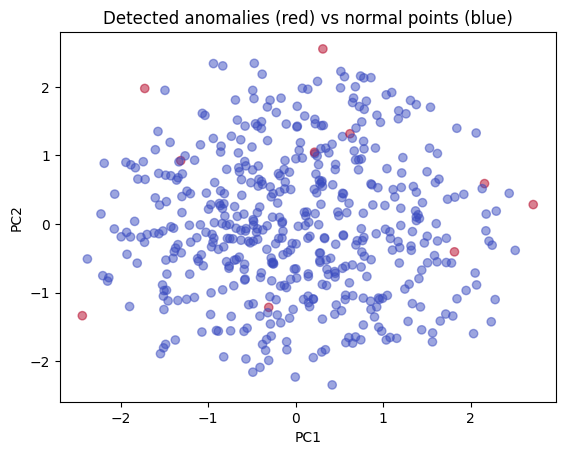

In [3]:
# @title Fit an Isolation Forest anomaly detector
from pyod.models.iforest import IForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

clf = IForest(random_state=42, contamination=0.02)
clf.fit(X_scaled)

scores = clf.decision_function(X_scaled)
y_pred = clf.predict(X_scaled)  # 0 = inlier, 1 = outlier

print("Number of anomalies detected:", int(y_pred.sum()))

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, cmap="coolwarm", alpha=0.5)
plt.title("Detected anomalies (red) vs normal points (blue)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
